# **Capstone Project: NLP based Automatic Ticket Assignment**

**Project Objective**
Build a classifier that can classify the tickets using NLP based model

**Dataset**
The dataset is collected from https://drive.google.com/file/d/1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab Notebooks/DataSets'

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn import svm
from xgboost import XGBClassifier

Using TensorFlow backend.


Install language conversion APIs

In [0]:
!pip install googletrans
!pip install langdetect

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=a2c14c4246d96a72f027c510cf25ffa3d6edf32bf5f86502cd940164e93b7472
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans
     |████████████████████████████████| 983kB 50.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=75b5c90e7781543b89d3ccae6b1c44b2cc9e86a9f510846860ec96b9a6afc573
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [0]:
os.chdir(project_path)

In [0]:
dfTicketAssignments = pd.read_excel('TicketAssignments.xlsx', header=0,names=['ShortDesc','Description','Caller','AssignmentGroup'])
dfTicketAssignments.head()

,ShortDesc,Description,Caller,AssignmentGroup
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


### Basic Dataset Analysis

In [0]:
dfTicketAssignments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
ShortDesc          8492 non-null object
Description        8499 non-null object
Caller             8500 non-null object
AssignmentGroup    8500 non-null object
dtypes: object(4)
memory usage: 265.8+ KB


In [0]:
dfTicketAssignments.shape

(8500, 4)

There are 8500 rows and 4 columns in the dataset

In [0]:
dfTicketAssignments.describe(include='all')

,ShortDesc,Description,Caller,AssignmentGroup
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976



*   Short Description column has missing 8 values
*   Description column has 1 missing value
*   Caller has no missing data
*   Same Assignment Group has no missing data

---


*   There are 74 unique Assignment Groups
*   GRP_0 has the maximum frequency of 3976




In [0]:
dfTicketAssignments.isnull().sum()

ShortDesc          8
Description        1
Caller             0
AssignmentGroup    0
dtype: int64

Short Desc has 8 missing values and Description column has 1 missing value in the complete dataset. Rest all other columns have values available for each row

In [0]:
nan_sd_rows = dfTicketAssignments[dfTicketAssignments['ShortDesc'].isnull()]
print(nan_sd_rows)

print('-----------------------------------------------------------------------')
nan_desc_rows = dfTicketAssignments[dfTicketAssignments['Description'].isnull()]
print(nan_desc_rows)

     ShortDesc  ... AssignmentGroup
2604       NaN  ...          GRP_34
3383       NaN  ...           GRP_0
3906       NaN  ...           GRP_0
3910       NaN  ...           GRP_0
3915       NaN  ...           GRP_0
3921       NaN  ...           GRP_0
3924       NaN  ...           GRP_0
4341       NaN  ...           GRP_0

[8 rows x 4 columns]
-----------------------------------------------------------------------
                     ShortDesc Description             Caller AssignmentGroup
4395  i am locked out of skype         NaN  viyglzfo ajtfzpkb           GRP_0


#### Exploring Assignment Groups

In [0]:
dfTicketAssignments.AssignmentGroup.value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_73       1
GRP_61       1
GRP_35       1
GRP_64       1
GRP_67       1
Name: AssignmentGroup, Length: 74, dtype: int64

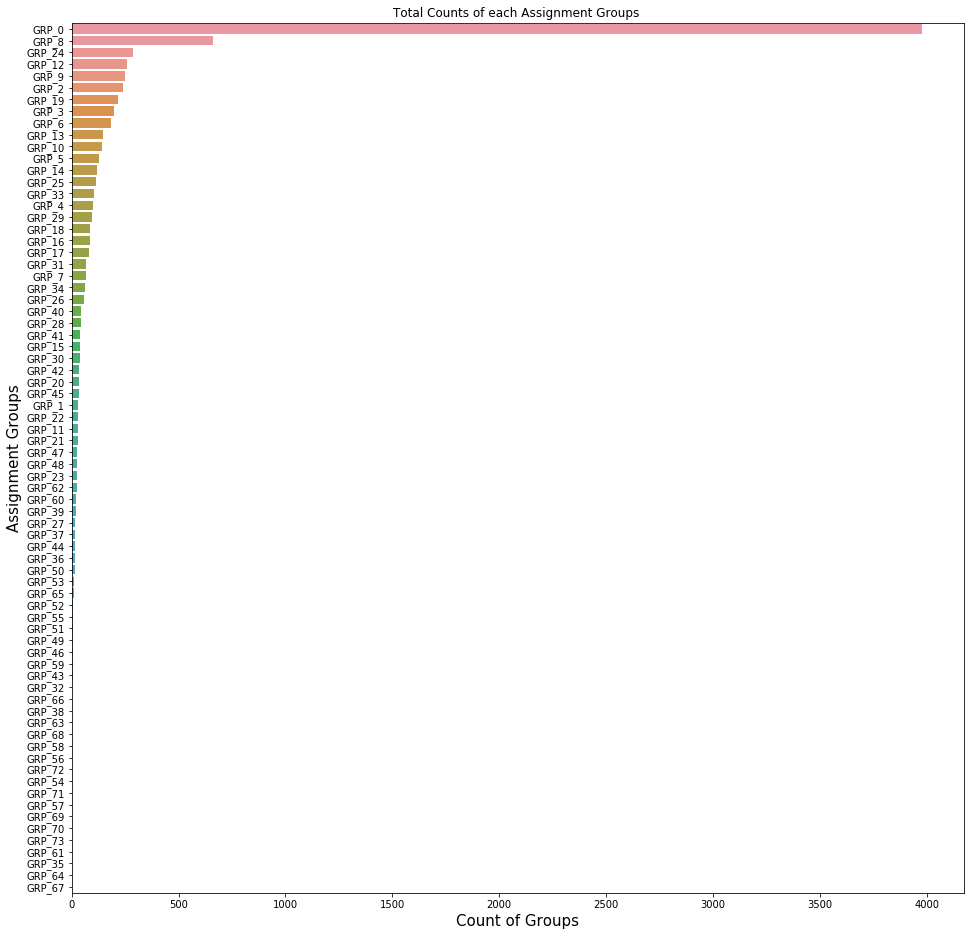

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,16))

x = dfTicketAssignments.AssignmentGroup.value_counts()
sns.barplot(x, x.index, ax=ax1)
plt.title('Total Counts of each Assignment Groups ')
plt.gca().set_xlabel('Count of Groups',fontsize=15)
plt.gca().set_ylabel('Assignment Groups',fontsize=15)

plt.show()

#### Exploring Caller Column

In [0]:
dfTicketAssignments.groupby(['Caller']).size().sort_values(ascending=False).head(20)

Caller
bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
jloygrwh acvztedi     64
spxqmiry zpwgoqju     63
oldrctiu bxurpsyi     57
olckhmvx pcqobjnd     54
dkmcfreg anwmfvlg     51
jyoqwxhz clhxsoqy     51
efbwiadp dicafxhv     45
afkstcev utbnkyop     32
gzhapcld fdigznbk     30
mnlazfsr mtqrkhnx     28
uvrbhlnt bjrmalzi     27
entuakhp xrnhtdmk     25
vzqomdgt jwoqbuml     24
jionmpsf wnkpzcmv     24
bozdftwx smylqejw     23
dtype: int64

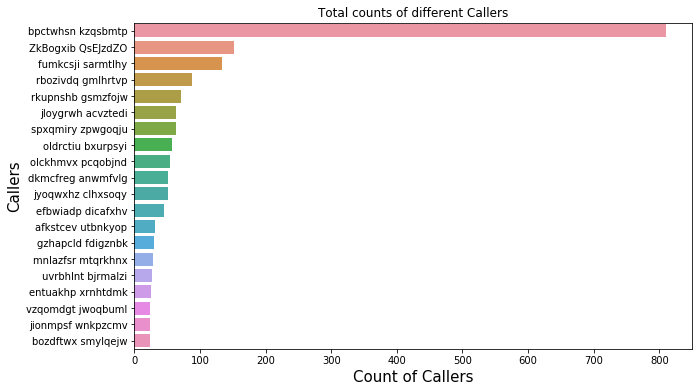

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,6))

x = dfTicketAssignments.groupby(['Caller']).size().sort_values(ascending=False).head(20)
sns.barplot(x, x.index, ax=ax1)
plt.title('Total counts of different Callers')
plt.gca().set_xlabel('Count of Callers',fontsize=15)
plt.gca().set_ylabel('Callers',fontsize=15)

plt.show()

#### Insight on Short Description column

In [0]:
# let's take top 20 records
dfTicketAssignments.ShortDesc.value_counts()[:20]

password reset                                  38
windows password reset                          29
account locked in ad                            24
windows account locked                          23
erp SID_34 account unlock                       19
unable to connect to vpn                        18
account locked.                                 18
login issue                                     18
blank call                                      18
erp SID_34 password reset                       17
account unlock                                  17
erp access issue                                17
error login on to the SID_34 system.            16
unable to launch outlook                        15
erp SID_34 account locked                       15
erp SID_34 account locked                       15
erp SID_34 account unlock and password reset    14
erp SID_34 password reset.                      14
unable to login to skype                        13
mobile device activation       

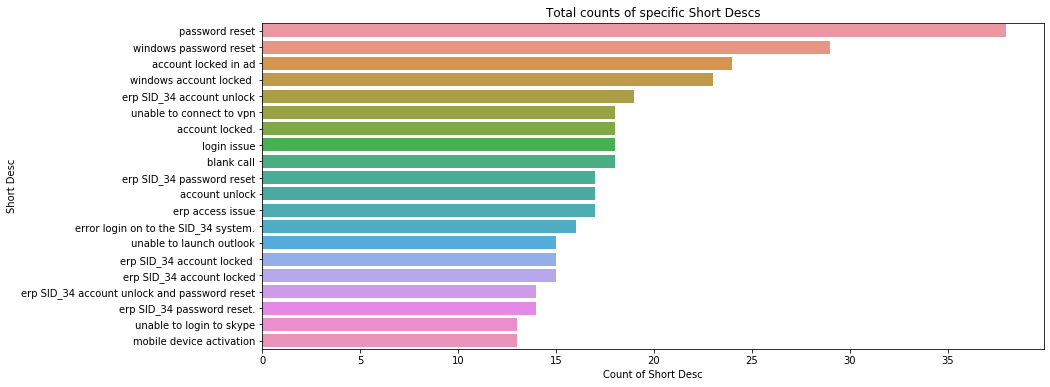

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))

x = dfTicketAssignments.ShortDesc.value_counts()[:20]
sns.barplot(x, x.index, ax=ax1)
plt.title('Total counts of specific Short Descs')
plt.gca().set_xlabel('Count of Short Desc')
plt.gca().set_ylabel('Short Desc')

plt.show()

#### Let's see the grouping of short description with different groups

In [0]:
dfSDG = dfTicketAssignments.groupby(['ShortDesc','AssignmentGroup']).size().sort_values(ascending=False).reset_index()
dfSDG.head(10)

,ShortDesc,AssignmentGroup,0
0,password reset,GRP_0,38
1,windows password reset,GRP_0,29
2,account locked in ad,GRP_0,24
3,windows account locked,GRP_0,23
4,erp SID_34 account unlock,GRP_0,19
5,login issue,GRP_0,18
6,blank call,GRP_0,18
7,erp SID_34 password reset,GRP_0,17
8,account unlock,GRP_0,17
9,account locked.,GRP_0,16


#### Exploring number of word counts in each short desc and decsription column

In [0]:
dfTicketAssignments['ShortDescWordCounts'] = dfTicketAssignments.ShortDesc.str.len()
dfTicketAssignments['DescriptionWordCounts'] = dfTicketAssignments.Description.str.len()

dfTicketAssignments.head()

,ShortDesc,Description,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,11.0,206.0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,7.0,194.0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,18.0,87.0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29.0,29.0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12.0,12.0


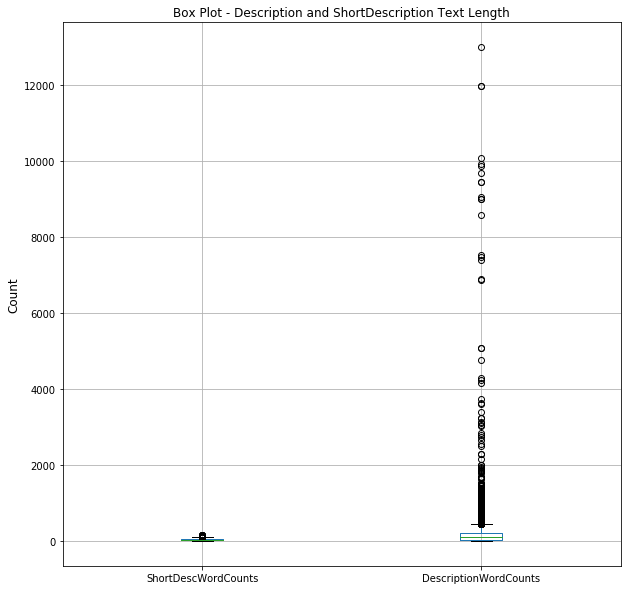

In [0]:
plt.figure(figsize=(10,10))
#plt.xlabel("Description Char Count", fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.title("Box Plot - Description and ShortDescription Text Length")
dfTicketAssignments.boxplot(grid=True)

In [0]:
dfTicketAssignments.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ShortDescWordCounts,8492.0,47.263542,27.040290,1.0,26.0,41.0,62.0,159.0
DescriptionWordCounts,8499.0,204.051888,519.699221,1.0,41.0,106.0,201.0,13001.0


[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

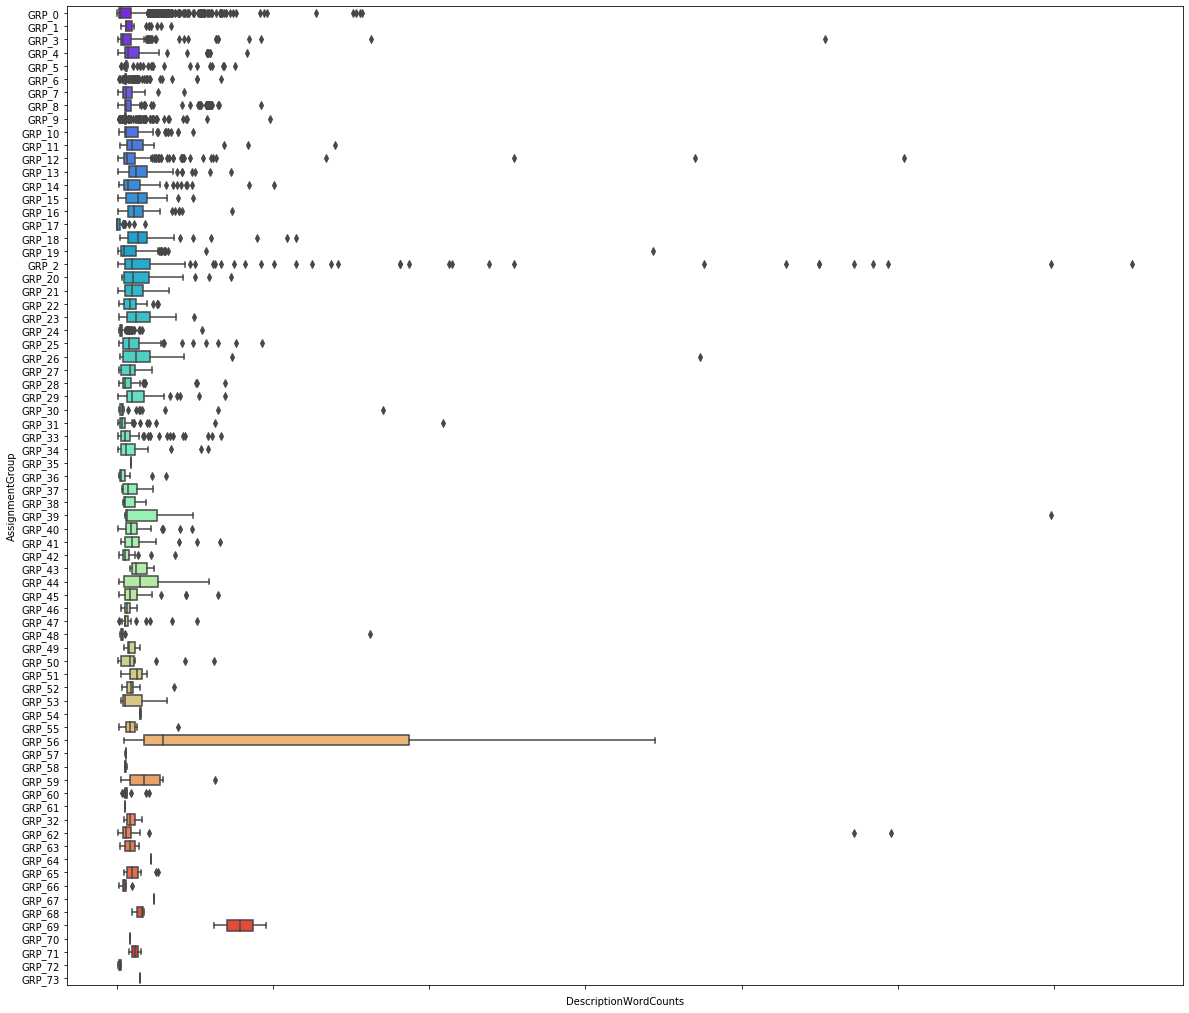

In [0]:
fig, ax = plt.subplots(figsize=(20, 18))
g = sns.boxplot(ax=ax,x='DescriptionWordCounts',y='AssignmentGroup',data=dfTicketAssignments,palette='rainbow')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

#### Grouping of Caller and Assignment Groups

In [0]:
groupByCaller = dfTicketAssignments.groupby(['AssignmentGroup','Caller'])
groupByCaller.size().unstack()

Caller,DEsowkrH sciejzNE,HdOuWxAt qfKdlJMx,ZkBogxib QsEJzdZO,abiuclvj brziktno,abtknpew ifcekjdb,abyfsqod baezguci,acmglkti cwgxrabu,acqpinyd ecygimqd,acteiqdu bferalus,acwoflmg lvwmshcr,adgvefwp dwasygtb,adlkywmc knzbuowr,advqtkeu uypkfisq,adxuzbcv uojxrivy,aedwrpvo qbpafrsx,aedzqlvj mkosyxgh,aeiljfxg hzwxtyjr,aeophctw nvjyhizu,aeozwlch lkiocfbn,aetvprsf ewmcrqja,aexbclqv zvapcslb,aeykqxlr brpdswvu,afbcmwsu tjgciswl,afijkocw rjtxslpa,afkstcev utbnkyop,afplnyxb eiomnuba,afslkeui qgzfptjw,afwzehqs jfbxegac,agjzikpf nhfrbxek,aglsimtd ovnyhizx,aguxobqs upgtdafh,agyvbnwz mxsonkdc,agzswjku kqwofdjl,ahbwvjct sfonkwra,ahlqgjwx wbsfavhg,ahmfwdxp frkmcqhg,ahmgtlyf ofgxcrys,ahuztyxg zlrwshfb,ahydmrbu fjymgtvo,aikejxpb xdavwocg,...,zqpyrxsn zihmunyb,zqrnveyx hajtfmcd,zqvpaxry yvzodtqp,zqyikobt ufxamgwr,zrbxcndu lxrsoenp,zrcfyiea gynbmopr,zreijwsb jnrxugpd,zrpemyab xvzwcbha,zscohabw qorvugzf,zslugaxq dtwlrofu,zsqabokr xbtsaodr,zstkagwu jlyrhdcf,zsulhnxd gexdzoqy,ztdgvclp gzcalstq,zthxyfpn ctsgrafo,ztlvkmyi xldyitwz,ztnpeshl vmdyglqn,ztrpuvdf jlahkmdv,ztswnaom lrapiwex,zuangtpq xpnscghk,zujpycos pogmachd,zupifghd vdqxepun,zuxcfonv nyhpkrbe,zuyimtsf qjtimdsp,zvenmiap kocjpnle,zvjwleuo tdfqgcal,zvwrklfa pguesbno,zwirhcol narzlmfw,zwqveghb rxdmstng,zxlhkpfi zylaghei,zxobmreq udikorhv,zxopwyak zrbfkimx,zxvjsipd jbzmgyvd,zyblacuk mvjqwgzn,zyheqclo mrznuplg,zylaexnv pvkzbduh,zylwdbig wdkbztjp,zymdwqsi jzvbthil,zywoxerf paqxtrfk,zyxjagro vjgozhpn
AssignmentGroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GRP_0,NaN,1.0,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,NaN,2.0,NaN,1.0,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,3.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,NaN,2.0,1.0,7.0,1.0,2.0,NaN,1.0,3.0,1.0,3.0,5.0,NaN,3.0,NaN,1.0,3.0,1.0,1.0,9.0,2.0
GRP_1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRP_10,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRP_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRP_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRP_71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRP_72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

#### Insight on Description Column

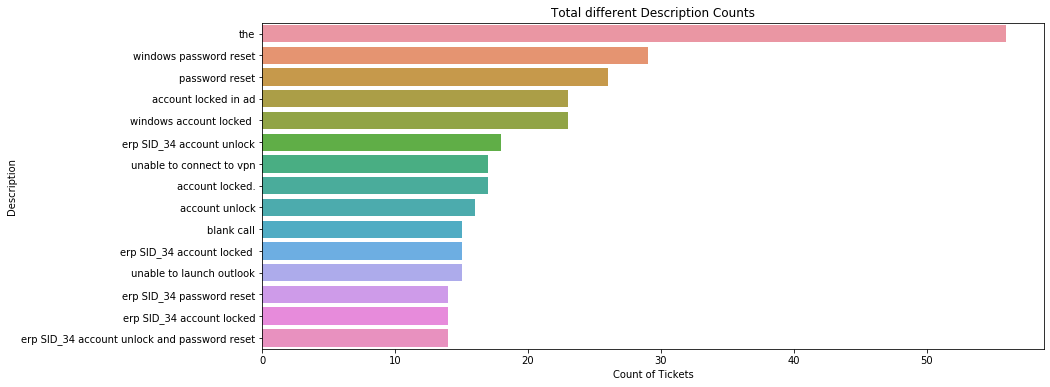

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))

x = dfTicketAssignments.Description.value_counts()[:15]
sns.barplot(x, x.index, ax=ax1)
plt.title('Total different Description Counts')
plt.gca().set_xlabel('Count of Tickets')
plt.gca().set_ylabel('Description')

plt.show()

#### Analysis:
- Uneven distribution of data across Assignment groups. 82% of total tickets are assigned to 15 groups from total of 74 groups.
- Uneven distribution of data for Caller. One of the caller has 800 tickets while many of them have one ticket.

### Some more basic EDAs

### **Basic feature extraction using text data**

#### Number of Words

In [0]:
dfTicketAssignments['ShortDesc'] = dfTicketAssignments['ShortDesc'].astype(str)
dfTicketAssignments['Description'] = dfTicketAssignments['Description'].astype(str)

dfTicketAssignments['ShortDesc'] = dfTicketAssignments['ShortDesc'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfTicketAssignments['Description'] = dfTicketAssignments['Description'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### Combined ShortDesc and Description Column
Some tickets have more meaningful value for "Short description" while many others have "Description" with more meaningful values. We will create a combined field by concatenating two fields

In [0]:
dfTicketAssignments['CombinedDescription'] = dfTicketAssignments['ShortDesc'] + str(' ') + dfTicketAssignments['Description']
dfTicketAssignments.isnull().sum()

ShortDesc                0
Description              0
Caller                   0
AssignmentGroup          0
ShortDescWordCounts      8
DescriptionWordCounts    1
CombinedDescription      0
dtype: int64

In [0]:
dfTicketAssignments.head()

,ShortDesc,Description,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue -verified user details.(employee# ...
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com hel...,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook received from: hmjdrvpb.komuaywn@gmail...
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com hi ...,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log in to vpn received from: eylqgodm.ybq...
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable to access hr_tool page unable to access...
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12.0,12.0,skype error skype error


In [0]:
dfTicketAssignments.drop(['Description','ShortDesc'], axis=1, inplace=True)

In [0]:
dfTicketAssignments.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue -verified user details.(employee# ...
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook received from: hmjdrvpb.komuaywn@gmail...
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log in to vpn received from: eylqgodm.ybq...
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable to access hr_tool page unable to access...
4,owlgqjme qhcozdfx,GRP_0,12.0,12.0,skype error skype error


Translate the non-english tickets to english 
In this German is having larget count compared to other languages. Focus will be to translate this and drop others which may constitute only 5% of the data

In [0]:
import googletrans
from googletrans import Translator
translator = Translator()
from langdetect import detect
languages = googletrans.LANGUAGES

#### Language detection algorithm is Non-deterministic: 
- For text which is either too short or ambiguous, we might get different results every time we run it. To enforce consistent results, call following code before the first language detection
- Creating a new column in the dataset and filling that with language name to differentiate each ticket, this will help in reducing the call to the google API to only non-english text

In [0]:
from langdetect import DetectorFactory 
DetectorFactory.seed = 0

In [0]:
dfTicketAssignments['Language'] = dfTicketAssignments['CombinedDescription'].apply(lambda x: detect(x))
dfTicketAssignments['Language'] = dfTicketAssignments['Language'].apply(lambda x: languages[x].upper())
dfTicketAssignments.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue -verified user details.(employee# ...,ENGLISH
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook received from: hmjdrvpb.komuaywn@gmail...,ENGLISH
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log in to vpn received from: eylqgodm.ybq...,ENGLISH
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable to access hr_tool page unable to access...,ENGLISH
4,owlgqjme qhcozdfx,GRP_0,12.0,12.0,skype error skype error,NORWEGIAN


[Text(0, 0, 'ENGLISH'),
 Text(0, 0, 'NORWEGIAN'),
 Text(0, 0, 'SPANISH'),
 Text(0, 0, 'ITALIAN'),
 Text(0, 0, 'AFRIKAANS'),
 Text(0, 0, 'SWEDISH'),
 Text(0, 0, 'CATALAN'),
 Text(0, 0, 'DUTCH'),
 Text(0, 0, 'DANISH'),
 Text(0, 0, 'FRENCH'),
 Text(0, 0, 'INDONESIAN'),
 Text(0, 0, 'FINNISH'),
 Text(0, 0, 'GERMAN'),
 Text(0, 0, 'SLOVENIAN'),
 Text(0, 0, 'WELSH'),
 Text(0, 0, 'ESTONIAN'),
 Text(0, 0, 'POLISH'),
 Text(0, 0, 'FILIPINO'),
 Text(0, 0, 'ROMANIAN'),
 Text(0, 0, 'CROATIAN'),
 Text(0, 0, 'ALBANIAN'),
 Text(0, 0, 'TURKISH'),
 Text(0, 0, 'PORTUGUESE'),
 Text(0, 0, 'SLOVAK'),
 Text(0, 0, 'LITHUANIAN'),
 Text(0, 0, 'CZECH')]

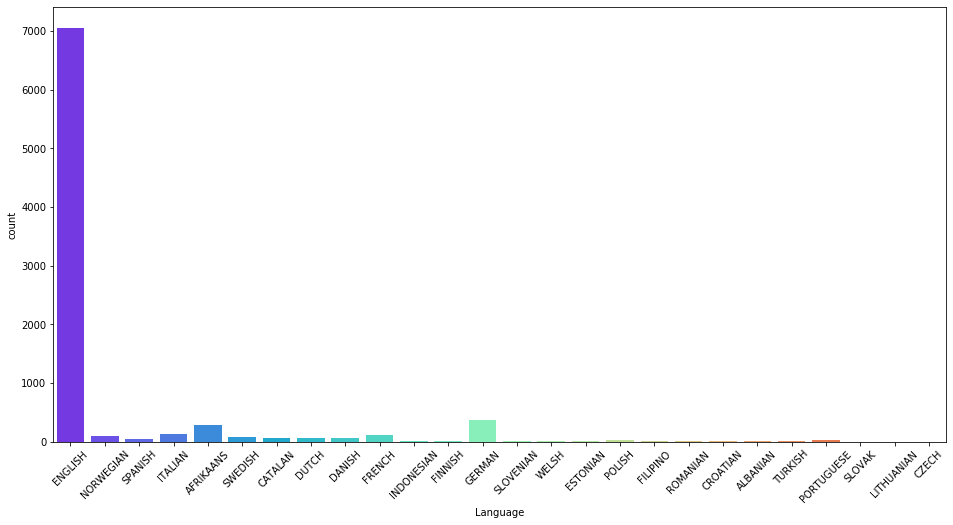

In [0]:
fig, ax = plt.subplots(figsize=(16, 8))
g = sns.countplot(ax=ax,x='Language',data=dfTicketAssignments,palette='rainbow')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [0]:
english_tickets = len(dfTicketAssignments[dfTicketAssignments['Language'] == 'ENGLISH'])
non_english_tickets = len(dfTicketAssignments[dfTicketAssignments['Language'] != 'ENGLISH'])
languages = pd.DataFrame(columns=['Language','Percentage'])
languages = languages.append({'Language':'English', 'Percentage':(english_tickets/8500)*100}, ignore_index=True)
languages = languages.append({'Language':'Non-English', 'Percentage':(non_english_tickets/8500)*100}, ignore_index=True)
languages

,Language,Percentage
0,English,83.035294
1,Non-English,16.964706


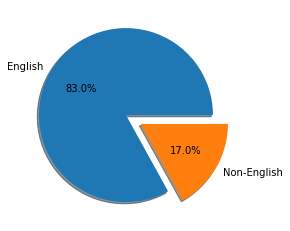

In [0]:
# Pie chart for English Vs Non-English languages
plt.figure(figsize=(4,4))
plt.pie(data=languages, x = 'Percentage', labels='Language', radius=1, shadow=True, autopct='%1.1f%%', explode=(0,0.2))
plt.savefig("LanguagesDist.png")

In [0]:
dfTicketAssignments.groupby('Language')['Language'].count().sort_values(ascending=False)

Language
ENGLISH       7058
GERMAN         378
AFRIKAANS      277
ITALIAN        125
FRENCH         115
NORWEGIAN       93
SWEDISH         80
DANISH          72
DUTCH           69
CATALAN         57
SPANISH         50
POLISH          27
PORTUGUESE      24
FILIPINO        11
ROMANIAN        11
WELSH           11
SLOVENIAN        8
ESTONIAN         6
TURKISH          5
CROATIAN         5
ALBANIAN         5
INDONESIAN       4
FINNISH          4
LITHUANIAN       2
SLOVAK           2
CZECH            1
Name: Language, dtype: int64

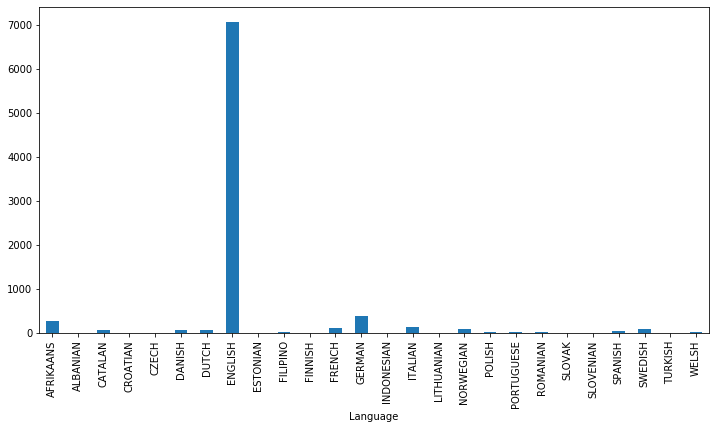

In [0]:
plt.figure(figsize=(12,6))
dfTicketAssignments.groupby('Language')['Language'].count().plot.bar()

In [0]:
# groupByLanguage = dfTicketAssignments.groupby(['Language','AssignmentGroup'])
# groupByLanguage.size().unstack()

Review detection of top 5 languages having maximum tickets

In [0]:
# dfTicketAssignments.head(10)

In [0]:
dfTicketAssignments[(dfTicketAssignments['Language'] == 'GERMAN')].head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language
223,vrfpyjwi nzhvgqiw,GRP_24,25.0,188.0,"probleme mit bluescreen . hallo , es ist erneu...",GERMAN
265,fcyuqvoj ajqeidlm,GRP_0,33.0,221.0,netweaver funktioniert nicht mehr received fro...,GERMAN
272,lpfwkotn keycvxsl,GRP_0,35.0,60.0,printer problem / issue information drucker / ...,GERMAN
304,wrcktgbd wzrgyunp,GRP_24,34.0,34.0,alte eq abholen \wrcktgbd wzrgyunp alte eq abh...,GERMAN
335,qrmbywzv mnvdcuhj,GRP_28,61.0,52.0,dringend : schulungsraum 1 . sprechanlage funk...,GERMAN


In [0]:
dfTicketAssignments[(dfTicketAssignments['Language'] == 'AFRIKAANS')].head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language
25,jqhtkfsm xoehtbnl,GRP_0,26.0,26.0,erp sid_37 password reset erp sid_37 password ...,AFRIKAANS
33,fsqwkbez eudsantq,GRP_0,18.0,18.0,ess password reset ess password reset,AFRIKAANS
52,jwhmqnye xlpvdwre,GRP_0,75.0,74.0,vip 2 - i need my password_management_tool pas...,AFRIKAANS
140,qcehailo wqynckxg,GRP_0,26.0,44.0,prtgghj4k45 password reset please reset hr_too...,AFRIKAANS
153,rjsulvat uanigkqc,GRP_0,14.0,14.0,outlook hangs. outlook hangs.,AFRIKAANS


In [0]:
dfTicketAssignments[(dfTicketAssignments['Language'] == 'ITALIAN')].head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language
19,ftsqkvre bqzrupic,GRP_0,23.0,23.0,unable to sign into vpn unable to sign into vpn,ITALIAN
29,hvskpglx bpsfxmon,GRP_0,31.0,31.0,unable to log in to erp sid_34 unable to log i...,ITALIAN
44,wxdrynag hlktazfm,GRP_0,32.0,32.0,unable to login to hr_tool etime unable to log...,ITALIAN
131,vtnkwxhr tqxrglvh,GRP_0,20.0,20.0,unable to access vpn unable to access vpn,ITALIAN
145,qifzkoej etbmgjvo,GRP_0,39.0,73.0,unable to start dell 7350 2 in 1 device qifzko...,ITALIAN


In [0]:
dfTicketAssignments[(dfTicketAssignments['Language'] == 'FRENCH')].head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language
169,lvxakohq tsfnhowj,GRP_0,23.0,23.0,account unlock request. account unlock request.,FRENCH
186,yafxlpwi lhxvatkb,GRP_18,51.0,245.0,é’å²›å…´åˆæœºç”µshipment notificationé‚®ç®±è...,FRENCH
190,nyscufdq wjtcsahz,GRP_0,22.0,22.0,password reset request password reset request,FRENCH
213,rbozivdq gmlhrtvp,GRP_0,17.0,17.0,loud noise // gso loud noise // gso,FRENCH
227,wjkzgyxh pktcqbxu,GRP_0,17.0,17.0,sync emails issue sync emails issue,FRENCH


#### Analysis:
- langdetect works much better for longer strings where it can sample more n-grams. For short strings of a few words, it's unreliable.
- Tickets are in multiple languages. Tickets in five languages comprise of 93.4%
  - English   : 7058 (83%), 
  - German    : 378 (4.4%)
  - Afrikaans : 277 (3.3%)
  - Italian   : 125 (1.5%)
  - French    : 115 (1.4%)
- Language is detected more correctly for English and German but quite incorrectly for Afrikaans, Italian and French

In [0]:
groupByLanguage = dfTicketAssignments.groupby(['Language','AssignmentGroup'])
groupByLanguage.size().unstack()

AssignmentGroup,GRP_0,GRP_1,GRP_10,GRP_11,GRP_12,GRP_13,GRP_14,GRP_15,GRP_16,GRP_17,GRP_18,GRP_19,GRP_2,GRP_20,GRP_21,GRP_22,GRP_23,GRP_24,GRP_25,GRP_26,GRP_27,GRP_28,GRP_29,GRP_3,GRP_30,GRP_31,GRP_32,GRP_33,GRP_34,GRP_35,GRP_36,GRP_37,GRP_38,GRP_39,GRP_4,GRP_40,GRP_41,GRP_42,GRP_43,GRP_44,GRP_45,GRP_46,GRP_47,GRP_48,GRP_49,GRP_5,GRP_50,GRP_51,GRP_52,GRP_53,GRP_54,GRP_55,GRP_56,GRP_57,GRP_58,GRP_59,GRP_6,GRP_60,GRP_61,GRP_62,GRP_63,GRP_64,GRP_65,GRP_66,GRP_67,GRP_68,GRP_69,GRP_7,GRP_70,GRP_71,GRP_72,GRP_73,GRP_8,GRP_9
Language,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFRIKAANS,237.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,1.0,5.0,2.0,NaN,NaN,NaN,NaN,13.0,3.0,1.0,1.0,NaN,NaN,1.0,NaN,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALBANIAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CATALAN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CROATIAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CZECH,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DANISH,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,NaN,NaN,1.0,NaN,15.0,16.0,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
DUTCH,34.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,18.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
ENGLISH,3168.0,30.0,136.0,29.0,223.0,140.0,114.0,37.0,83.0,75.0,84.0,197.0,235.0,34.0,29.0,31.0,25.0,68.0,96.0,53.0,16.0,34.0,92.0,195.0,3.0,22.0,2.0,29.0,47.0,1.0,13.0,16.0,3.0,19.0,100.0,42.0,40.0,5.0,5.0,14.0,34.0,4.0,27.0,1.0,3.0,127.0,13.0,8.0,8.0,11.0,2.0,7.0,3.0,2.0,3.0,5.0,179.0,20.0,1.0,10.0,3.0,1.0,10.0,4.0,1.0,3.0,2.0,67.0,1.0,2.0,2.0,1.0,659.0,249.0
ESTONIAN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Delete tickets in languages other than English and German
- Language is detected more correctly for English and German but quite incorrectly for Afrikaans, Italian and French. 
- We will delete tickets in languages other than English and German. 
- We will translate only for German language

In [0]:
dfTicketAssignments.head(2)

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue -verified user details.(employee# ...,ENGLISH
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook received from: hmjdrvpb.komuaywn@gmail...,ENGLISH


In [0]:
dfTicketAssignments = dfTicketAssignments.drop(dfTicketAssignments[(dfTicketAssignments['Language'] != 'ENGLISH') & (dfTicketAssignments['Language'] != 'GERMAN')].index)

In [0]:
dfTicketAssignments.groupby('Language')['Language'].count().sort_values(ascending=False)

Language
ENGLISH    7058
GERMAN      378
Name: Language, dtype: int64

#### Translate tickets to English

In [0]:
def fn_translate(desc,lang):
  try:
    if lang == 'ENGLISH':
        return desc
    else:
        return translator.translate(desc).text
  except:
    return desc

In [0]:
dfTicketAssignments['EnglishDescription'] = dfTicketAssignments.apply(lambda x: fn_translate(x['CombinedDescription'], x['Language']), axis=1)

In [0]:
dfTicketAssignments['NewLanguage'] = dfTicketAssignments['EnglishDescription'].apply(lambda x: detect(x))
# dfTicketAssignments[dfTicketAssignments['Language']=='GERMAN'].count()

In [0]:
dfTicketAssignments[(dfTicketAssignments['Language'] != 'ENGLISH')].head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage
223,vrfpyjwi nzhvgqiw,GRP_24,25.0,188.0,"probleme mit bluescreen . hallo , es ist erneu...",GERMAN,"problems with blue screen. hello, it happened ...",en
265,fcyuqvoj ajqeidlm,GRP_0,33.0,221.0,netweaver funktioniert nicht mehr received fro...,GERMAN,netweaver stops working received from: fcyuqvo...,en
272,lpfwkotn keycvxsl,GRP_0,35.0,60.0,printer problem / issue information drucker / ...,GERMAN,printer problem / issue information printer / ...,en
304,wrcktgbd wzrgyunp,GRP_24,34.0,34.0,alte eq abholen \wrcktgbd wzrgyunp alte eq abh...,GERMAN,old eq pick \ wrcktgbd wzrgyunp old eq pick \ ...,pl
335,qrmbywzv mnvdcuhj,GRP_28,61.0,52.0,dringend : schulungsraum 1 . sprechanlage funk...,GERMAN,urgent: training room. 1 intercom does not wor...,en


**Meta Features**

Distributions of meta features in classes and datasets can be helpful to identify ticket context. Ticket descriptions are not written in a formal way We can see many typos because they are coming from individual callers. The meta features used for the analysis are;

*   word_count number of words in text
*   unique_word_count number of unique words in text
*   stop_word_count number of stop words in text
*   url_count number of urls in text
*   mean_word_length average character count in words
*   char_count number of characters in text
*   punctuation_count number of punctuations in text


In [0]:
dfCopySet = dfTicketAssignments.copy()

In [0]:
dfCopySet['CombinedDescription'] = dfCopySet['EnglishDescription']

In [0]:
from collections import OrderedDict
# dfCopySet['CombinedDescription'] = dfCopySet['CombinedDescription'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')
dfCopySet['CombinedDescription'] = (dfCopySet['CombinedDescription'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
dfCopySet['CombinedDescription'].head()

0    login issue -verified user details.(employee# ...
1    outlook received from: hmjdrvpb.komuaywn@gmail...
2    cant log in to vpn received from: eylqgodm.ybq...
3                        unable to access hr_tool page
5          unable to log in engineering tool and skype
Name: CombinedDescription, dtype: object

In [0]:
dfCopySet['CombinedDescriptionWordCount'] = dfCopySet['CombinedDescription'].apply(lambda x : len(str(x).split(" ")))
dfCopySet[['CombinedDescription', 'CombinedDescriptionWordCount']].head()

,CombinedDescription,CombinedDescriptionWordCount
0,login issue -verified user details.(employee# ...,28
1,outlook received from: hmjdrvpb.komuaywn@gmail...,24
2,cant log in to vpn received from: eylqgodm.ybq...,13
3,unable to access hr_tool page,5
5,unable to log in engineering tool and skype,8


In [0]:
dfCopySet['CharCount'] = dfCopySet['CombinedDescription'].str.len()
dfCopySet[['CombinedDescription', 'CharCount','CombinedDescriptionWordCount']].head()

,CombinedDescription,CharCount,CombinedDescriptionWordCount
0,login issue -verified user details.(employee# ...,183,28
1,outlook received from: hmjdrvpb.komuaywn@gmail...,177,24
2,cant log in to vpn received from: eylqgodm.ybq...,81,13
3,unable to access hr_tool page,29,5
5,unable to log in engineering tool and skype,43,8


### Data Pre-processing

#### Remove Punctuations

In [0]:
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text

In [0]:
dfCopySet['CombinedDescription'] = dfCopySet['CombinedDescription'].apply(remove_punctuations)

#### Remove Spaces

In [0]:
dfCopySet.CombinedDescription = dfCopySet.CombinedDescription.apply(lambda x: x.strip())
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee ...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook received from hmjdrvpb komuaywn gmail...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log in to vpn received from eylqgodm ybq...,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable to access hr tool page,ENGLISH,unable to access hr_tool page unable to access...,en,5,29
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable to log in engineering tool and skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43


#### Convert to Lowercase

In [0]:
dfCopySet['CombinedDescription'] = dfCopySet['CombinedDescription'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#### Remove Stopwords
For basic NLP techniques like BOW, Count Vectorizer or TF-IDF, removing stopwords is a good idea as it will reduce the noise

In [0]:
def getRegexList():
    regexList = []
    regexList += ['From:(.*)\r\n']  # from line
    regexList += ['ticket[_]*[\s]*[0-9]*'] # ticket id
    regexList += ['Sent:(.*)\r\n']  # sent to line
    regexList += ['Received:(.*)\r\n']  # received data line
    regexList += ['To:(.*)\r\n']  # to line
    regexList += ['CC:(.*)\r\n']  # cc line
    regexList += ['\[cid:(.*)]']  # images cid
    regexList += ['https?:[^\]\n\r]+']  # https & http
    regexList += ['Subject:']
    regexList += ['[\w\d\-\_\.]+@[\w\d\-\_\.]+']  # emails
    regexList += ['[0-9][\-0–90-9 ]+']  # phones
    regexList += ['[0-9]']  # numbers
    regexList += ['[^a-zA-z 0-9]+']  # anything that is not a letter
    regexList += ['[\r\n]']  # \r\n
    regexList += [' [a-zA-Z] ']  # single letters
    regexList += ["  "]  # double spaces
    regexList += ['^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$']
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+']
    regexList += ['Subject:']
    regexList += ['[^a-zA-Z]']

    return regexList

In [0]:
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

In [0]:
def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)
    return dataset

In [0]:
columnsToClean = ['CombinedDescription']

dfCopySet = cleanDataset(dfCopySet, columnsToClean, getRegexList())

In [0]:
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook received from hmjdrvpb komuaywn gmail ...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log in to vpn received from eylqgodm ybqk...,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable to access hr tool page,ENGLISH,unable to access hr_tool page unable to access...,en,5,29
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable to log in engineering tool and skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43


#### Number of Stop words

In [0]:
stop_words = []
stop_words += ["good", "evening", "night", "afternoon", "ca", "nt", "i", "vip", "llv", "xyz", "cid", "image", "gmail","co", "in", "com", "ticket", "company", "received", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "nobody", "non", "none", "nonetheless", "noone", "normally", "nos", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]

In [0]:
dfCopySet.CombinedDescription = dfCopySet.CombinedDescription.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook hmjdrvpb komuaywn team meetings skype ...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn eylqgodm ybqkwiam cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43


In [0]:
caller_list = dfCopySet["Caller"].str.split(" ", n = 1, expand = True)
caller_fname = caller_list[0].to_list()
caller_lname = caller_list[1].to_list()

#### Remove Caller names from Description

In [0]:
#There are some Callers whose names are present in description and may be short description.
#Remove those from combined description column by referring Callers fname and lname list
dfCopySet.CombinedDescription = dfCopySet.CombinedDescription.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_fname]))
dfCopySet.CombinedDescription = dfCopySet.CombinedDescription.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_lname]))
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook team meetings skype meetings not appea...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43


### Word Cloud

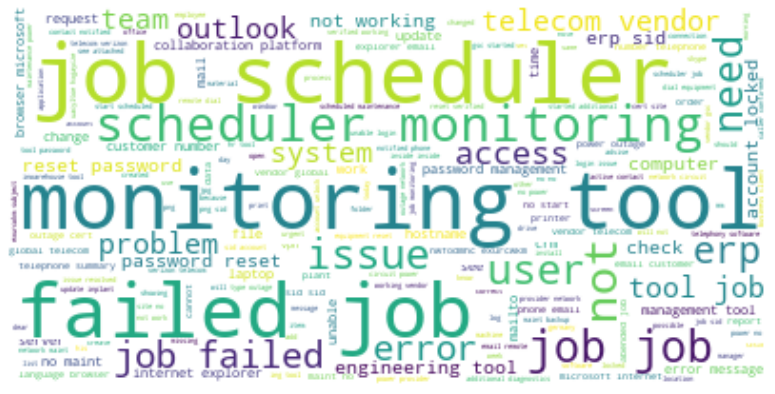

In [0]:
from wordcloud import WordCloud

text = " ".join(review for review in dfCopySet.CombinedDescription)
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
# from collections import Counter
# Counter(" ".join(dfCopySet['CombinedDescription']).split() ).most_common(30)

Uni-Gram

In [0]:
def get_top_description_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

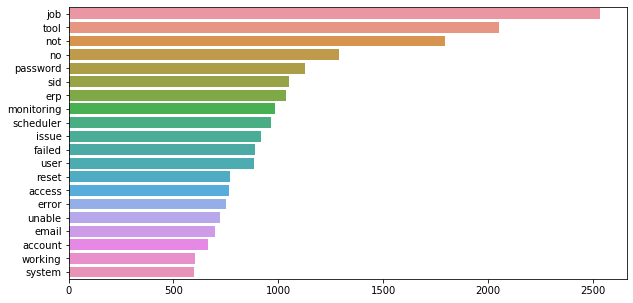

In [0]:
plt.figure(figsize=(10,5))
top_description_unigrams=get_top_description_unigrams(dfCopySet['CombinedDescription'])[:20]
x,y=map(list,zip(*top_description_unigrams))
sns.barplot(x=y,y=x)

Bi- Gram

In [0]:
def get_top_description_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

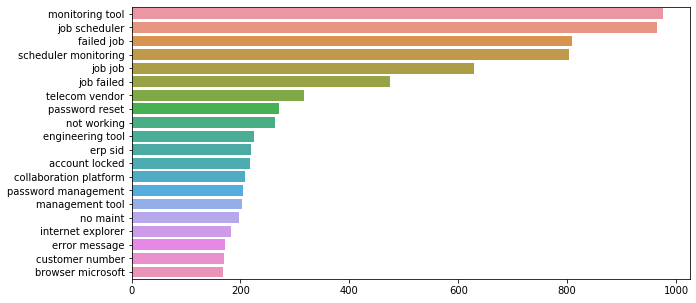

In [0]:
plt.figure(figsize=(10,5))
top_description_bigrams=get_top_description_bigrams(dfCopySet['CombinedDescription'])[:20]
x,y=map(list,zip(*top_description_bigrams))
sns.barplot(x=y,y=x)

Tri Grams


In [0]:
def get_top_description_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

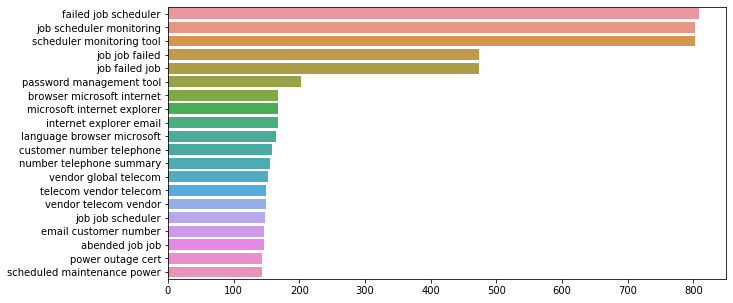

In [0]:
plt.figure(figsize=(10,5))
top_description_trigrams=get_top_description_trigrams(dfCopySet['CombinedDescription'])[:20]
x,y=map(list,zip(*top_description_trigrams))
sns.barplot(x=y,y=x)

### Tokenization

In [0]:
# Word tokenization
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

In [0]:
def tokenizeText(text):
  #  "nlp" Object is used to create documents with linguistic annotations.
  my_doc = nlp(text)
  # Create list of word tokens
  token_list = []
  for token in my_doc:
    token_list.append(token.text)
  return token_list

In [0]:
dfCopySet['Tokens'] = dfCopySet['CombinedDescription'].apply(lambda x: tokenizeText(x))

In [0]:
print(dfCopySet.shape)
dfCopySet.head()

(7436, 11)


,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount,Tokens
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183,"[login, issue, verified, user, details, employ..."
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook team meetings skype meetings not appea...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177,"[outlook, team, meetings, skype, meetings, not..."
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81,"[ca, nt, log, vpn, can, not]"
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29,"[unable, access, hr, tool]"
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43,"[unable, log, engineering, tool, skype]"


In [0]:
dfCopySet.Tokens[3]

['unable', 'access', 'hr', 'tool']

In [0]:
#### Cleaning stop words after tokenization - there is libarary that keep cant as word
#cleanTokens = []
#for col_desc in range(len(dfCopySet.Tokens)):
#  str_token = dfCopySet.Tokens[col_desc]
#  cleanTokens.append([w for w in str_token if w not in stop_words] )
#
#dfCopySet['Tokens'] = cleanTokens

In [0]:
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount,Tokens
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183,"[login, issue, verified, user, details, employ..."
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook team meetings skype meetings not appea...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177,"[outlook, team, meetings, skype, meetings, not..."
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81,"[ca, nt, log, vpn, can, not]"
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29,"[unable, access, hr, tool]"
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43,"[unable, log, engineering, tool, skype]"


#### Remove Duplicates

In [0]:
# Python code to remove duplicate elements 
def RemovDupWordTokens(dupToken): 
    finalTokenlist = [] 
    for num in dupToken: 
        if num not in finalTokenlist: 
            finalTokenlist.append(num) 
    return finalTokenlist

In [0]:
# remove duplicates again from Tokens column
dfCopySet['Tokens'] = dfCopySet['Tokens'].apply(lambda x: RemovDupWordTokens(x))
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount,Tokens
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183,"[login, issue, verified, user, details, employ..."
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook team meetings skype meetings not appea...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177,"[outlook, team, meetings, skype, not, appearin..."
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81,"[ca, nt, log, vpn, can, not]"
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29,"[unable, access, hr, tool]"
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43,"[unable, log, engineering, tool, skype]"


### Lemmatization
- The goal of Lemmatization is to reduce the number of inflectional forms of words. This helps to reduce the size of the vocabulary and improve the volume of the feature space in the corpus.
- Lemmatization is more effective than stemming. It converts word into root word, rather than just stripping suffixes.

In [0]:
def lemmatizeText(text):
  text = ' '.join(map(str, text)) 
  # Implementing lemmatization
  lem = nlp(text)
  lemma_list = []
  # finding lemma for each word
  for word in lem:
    lemma_list.append(word.lemma_)
  return lemma_list

In [0]:
dfCopySet['LemmaWords'] = dfCopySet['Tokens'].apply(lambda x: lemmatizeText(x))

In [0]:
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount,Tokens,LemmaWords
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183,"[login, issue, verified, user, details, employ...","[login, issue, verify, user, detail, employee,..."
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook team meetings skype meetings not appea...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177,"[outlook, team, meetings, skype, not, appearin...","[outlook, team, meeting, skype, not, appear, c..."
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81,"[ca, nt, log, vpn, can, not]","[ca, not, log, vpn, can, not]"
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29,"[unable, access, hr, tool]","[unable, access, hr, tool]"
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43,"[unable, log, engineering, tool, skype]","[unable, log, engineer, tool, skype]"


In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def listToString(s):
  str1 = " "
  for ele in s:
    str1 = str1 + " " + ele
  return str1

In [0]:
dfCopySet['LemmaString'] = dfCopySet['LemmaWords'].apply(lambda x: listToString(x))

### Review Vocabulary size after removing Stopwords & Lemmatization

In [0]:
print('Word Count: ', dfCopySet['LemmaString'].apply(lambda x: len(x.split(' '))).sum())

Word Count:  111790


### Review Description length after removing Stopwords & Lemmatization

In [0]:
dfCopySet['NewLen'] = dfCopySet["LemmaString"].apply(len)
dfCopySet.sort_values(['NewLen'], ascending=False).head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount,Tokens,LemmaWords,LemmaString,NewLen
4087,ugyothfz ugrmkdhx,GRP_39,63.0,11968.0,security incidents sw magento sql injection so...,ENGLISH,security incidents - ( sw #in33895560 ) : mage...,en,980,8749,"[security, incidents, sw, magento, sql, inject...","[security, incident, sw, magento, sql, injecti...",security incident sw magento sql injection s...,3583
4089,ugyothfz ugrmkdhx,GRP_2,63.0,11968.0,security incidents sw magento sql injection so...,ENGLISH,security incidents - ( sw #in33895560 ) : mage...,en,981,8753,"[security, incidents, sw, magento, sql, inject...","[security, incident, sw, magento, sql, injecti...",security incident sw magento sql injection s...,3583
8002,ugyothfz ugrmkdhx,GRP_62,107.0,9912.0,security incidents sw possible locky ransomwar...,ENGLISH,security incidents - ( sw #in33544563 ) : poss...,en,838,7016,"[security, incidents, sw, possible, locky, ran...","[security, incident, sw, possible, locky, rans...",security incident sw possible locky ransomwa...,2860
7997,ugyothfz ugrmkdhx,GRP_2,107.0,9678.0,security incidents sw possible locky ransomwar...,ENGLISH,security incidents - ( sw #in33544563 ) : poss...,en,838,7016,"[security, incidents, sw, possible, locky, ran...","[security, incident, sw, possible, locky, rans...",security incident sw possible locky ransomwa...,2860
7995,ugyothfz ugrmkdhx,GRP_62,109.0,9440.0,security incidents dsw traffic sinkhole domain...,ENGLISH,security incidents - ( dsw #in33407676 ) : tra...,en,731,6172,"[security, incidents, dsw, traffic, sinkhole, ...","[security, incident, dsw, traffic, sinkhole, d...",security incident dsw traffic sinkhole domai...,2734


 Training: Average length of description 92.01331360946746
 Training: Std Deviation of description 140.9744805027955
 Training: Maximum length of description 3583


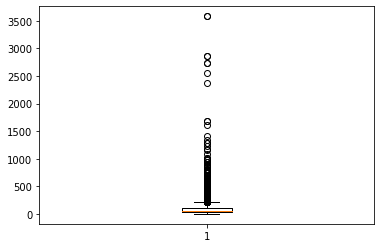

In [0]:
print(" Training: Average length of description", np.mean(dfCopySet['NewLen']))
print(" Training: Std Deviation of description", np.std(dfCopySet['NewLen']))
print(" Training: Maximum length of description", np.max(dfCopySet['NewLen']))
plt.boxplot(dfCopySet['NewLen'])
plt.show()

In [0]:
dfCopySet.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ShortDescWordCounts,7428.0,49.457593,27.516262,1.0,27.0,44.0,64.0,159.0
DescriptionWordCounts,7435.0,226.305044,550.950041,1.0,54.0,110.0,223.0,13001.0
CombinedDescriptionWordCount,7436.0,25.887574,41.059024,1.0,9.0,15.0,31.0,981.0
CharCount,7436.0,192.241259,354.108490,1.0,61.0,113.0,216.0,8753.0
NewLen,7436.0,92.013314,140.983961,1.0,33.0,55.0,108.0,3583.0


In [0]:
print("Records with length <= 100: ",dfCopySet[(dfCopySet['NewLen'] <= 100)].count() ['NewLen'], "  ", dfCopySet[(dfCopySet['NewLen'] <= 100)].count() ['NewLen']/7436*100, "%")
print("Records with length <= 200: ",dfCopySet[(dfCopySet['NewLen'] <= 200)].count() ['NewLen'], "  ", dfCopySet[(dfCopySet['NewLen'] <= 200)].count() ['NewLen']/7436*100, "%")
print("Records with length <= 300: ",dfCopySet[(dfCopySet['NewLen'] <= 300)].count() ['NewLen'], "  ", dfCopySet[(dfCopySet['NewLen'] <= 300)].count() ['NewLen']/7436*100, "%")
print("Records with length <= 400: ",dfCopySet[(dfCopySet['NewLen'] <= 400)].count() ['NewLen'], "  ", dfCopySet[(dfCopySet['NewLen'] <= 400)].count() ['NewLen']/7436*100, "%")

Records with length <= 100:  5369    72.2027972027972 %
Records with length <= 200:  6789    91.29908552985476 %
Records with length <= 300:  7215    97.02797202797203 %
Records with length <= 400:  7286    97.98278644432492 %


### Generating Features
For text analysis, the words in each text message will be our features. For this purpose, we will tokenize each word

### Vectorize the text using TF-IDF
TF-IDF is a scoring algorithm for words - that is a measure of how important a word is to a document.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vect = TfidfVectorizer()
tfidf_ts = vect.fit_transform(dfCopySet["LemmaString"])
features = vect.transform(dfCopySet["LemmaString"])

print(len(vect.vocabulary_))
print(tfidf_ts.shape)

9850
(7436, 9850)


In [0]:
feature_names = vect.get_feature_names()
dense = tfidf_ts.todense()
denselist = dense.tolist()
print(len(feature_names))

9850


In [0]:
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,aa,aac,aacount,aad,aae,aao,abandon,abap,abarbeiten,abb,abba,abc,abca,abd,abdhtyu,abend,abended,abeoucfj,abgebildet,abgrtyreu,abhay,abholen,abide,ability,abl,abort,abovementioned,abreu,abrurto,absence,absender,absent,absolutely,absolvieren,abstechprogramdntym,abwfnzw,acache,acb,acc,acccount,...,zredeploy,zrobi,zscr,zscxqdhoalaramdntyan,zsd,zsdr,zsdslsum,zsluxctw,zspvxrfk,zssid,zsywd,zsywdglgbpc,ztax,ztfn,ztnfhiwq,zttf,ztyhng,zu,zuehlke,zugang,zugordnet,zugriff,zugriffs,zuhoylts,zum,zuothryrt,zur,zurtxjbd,zust,zuteillisten,zvon,zvw,zw,zwip,zwkfzfqhveyrfplvnz,zwrglgb,zwrglgbsb,zwwirep,zzcmpgn,zzsdspc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Review most common words

In [0]:
df2 = pd.DataFrame(df.sum(), columns=['TfIdf']).reset_index()
df2.rename(columns={'index':'Word'}, inplace=True)

In [0]:
common_words = df2.nlargest(20, 'TfIdf')

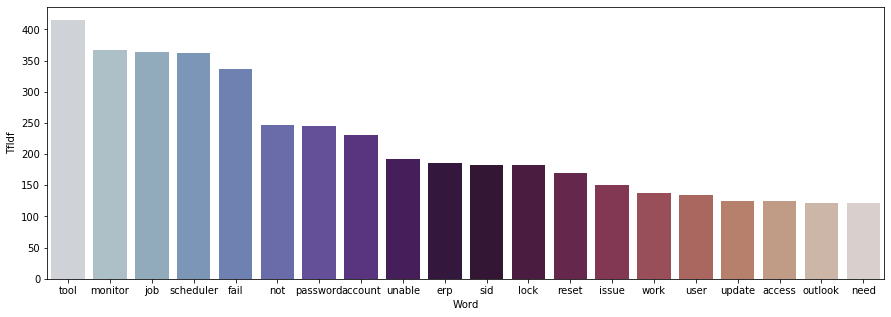

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=common_words, x='Word', y='TfIdf', palette='twilight')

### **Create Corpus and Embedding Matrix**

In [0]:
def create_corpus(df):
    corpus=[]
    for desc in tqdm(df['LemmaString'].astype(str)):
        words=[word.lower() for word in word_tokenize(desc) if((word.isalpha()==1))] # & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [0]:
corpus=create_corpus(dfCopySet)

100%|██████████| 7436/7436 [00:00<00:00, 8554.34it/s]


In [0]:
# corpus

In [0]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
MAX_LEN=100
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

desc_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [0]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 9853


In [0]:
num_words=len(word_index)+1
print(num_words)

9854


In [0]:
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 9853/9853 [00:00<00:00, 609984.90it/s]


In [0]:
embedding_matrix[1]

array([-1.91039994e-01,  1.76009998e-01,  3.69199991e-01, -5.03229976e-01,
       -4.75609988e-01,  1.57979995e-01, -1.16789997e-01,  2.10519999e-01,
        3.26519996e-01,  1.21940002e-01,  9.09439996e-02,  2.60890007e-01,
        7.62939990e-01,  6.96729985e-04, -5.00009991e-02, -4.48529989e-01,
        3.62390012e-01,  5.63449979e-01, -6.87020004e-01,  3.32370013e-01,
        3.12849998e-01, -1.42069995e-01,  3.53269994e-01, -1.64260000e-01,
       -1.06930003e-01,  7.77859986e-02, -1.77039996e-01, -9.28969979e-01,
        1.46799996e-01, -1.35849997e-01,  2.56819993e-01,  6.60189986e-01,
       -3.55690002e-01,  2.18380004e-01,  3.81729990e-01,  5.43370008e-01,
        1.01970002e-01,  3.52299988e-01, -2.55100012e-01, -1.51549995e-01,
       -6.74340010e-01,  1.69029996e-01,  1.64130002e-01, -5.38429976e-01,
       -1.74569994e-01, -2.85389990e-01,  7.40440011e-01, -6.75329983e-01,
       -2.33820006e-01, -1.35990000e+00,  3.02249998e-01, -1.49680004e-01,
        2.70429999e-01,  

### Clustering

In [0]:
dfCopySet.head()

,Caller,AssignmentGroup,ShortDescWordCounts,DescriptionWordCounts,CombinedDescription,Language,EnglishDescription,NewLanguage,CombinedDescriptionWordCount,CharCount,Tokens,LemmaWords,LemmaString,NewLen
0,spxjnwir pjlcoqds,GRP_0,11.0,206.0,login issue verified user details employee man...,ENGLISH,login issue -verified user details.(employee# ...,en,28,183,"[login, issue, verified, user, details, employ...","[login, issue, verify, user, detail, employee,...",login issue verify user detail employee mana...,106
1,hmjdrvpb komuaywn,GRP_0,7.0,194.0,outlook team meetings skype meetings not appea...,ENGLISH,outlook received from: hmjdrvpb.komuaywn@gmail...,en,24,177,"[outlook, team, meetings, skype, not, appearin...","[outlook, team, meeting, skype, not, appear, c...",outlook team meeting skype not appear calend...,77
2,eylqgodm ybqkwiam,GRP_0,18.0,87.0,cant log vpn cannot,ENGLISH,cant log in to vpn received from: eylqgodm.ybq...,en,13,81,"[ca, nt, log, vpn, can, not]","[ca, not, log, vpn, can, not]",ca not log vpn can not,24
3,xbkucsvz gcpydteq,GRP_0,29.0,29.0,unable access hr tool,ENGLISH,unable to access hr_tool page unable to access...,en,5,29,"[unable, access, hr, tool]","[unable, access, hr, tool]",unable access hr tool,23
5,eflahbxn ltdgrvkz,GRP_0,46.0,46.0,unable log engineering tool skype,ENGLISH,unable to log in to engineering tool and skype...,en,8,43,"[unable, log, engineering, tool, skype]","[unable, log, engineer, tool, skype]",unable log engineer tool skype,32


In [0]:
dfClustering = dfCopySet[['LemmaString','AssignmentGroup']]
dfClustering.head()

,LemmaString,AssignmentGroup
0,login issue verify user detail employee mana...,GRP_0
1,outlook team meeting skype not appear calend...,GRP_0
2,ca not log vpn can not,GRP_0
3,unable access hr tool,GRP_0
5,unable log engineer tool skype,GRP_0


#### Encode the Target column using Label Encoder

In [0]:
# Import label encoder 
from sklearn import preprocessing 
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dfClustering['AssignmentGroup']= label_encoder.fit_transform(dfClustering['AssignmentGroup']) 
  
dfClustering['AssignmentGroup'].unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 27, 28, 29,
       30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 57, 58, 26, 60, 61, 59, 43, 62, 44, 63, 64, 65,
       66, 24, 68, 69, 70, 71])

In [0]:
dfClustering.head()

,LemmaString,AssignmentGroup
0,login issue verify user detail employee mana...,0
1,outlook team meeting skype not appear calend...,0
2,ca not log vpn can not,0
3,unable access hr tool,0
5,unable log engineer tool skype,0


In [0]:
cls = MiniBatchKMeans(n_clusters=3, random_state=10)
cls.fit(embedding_matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=10,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [0]:
# predict cluster labels for new dataset
cls.predict(embedding_matrix)
# to get cluster labels for the dataset used while training
cls.labels_

array([0, 2, 2, ..., 0, 1, 0], dtype=int32)

In [0]:
cls.labels_.shape

(9854,)

In [0]:
# reduce the features to 2D
pca = PCA(n_components=3, random_state=10)
reduced_features = pca.fit_transform(embedding_matrix)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

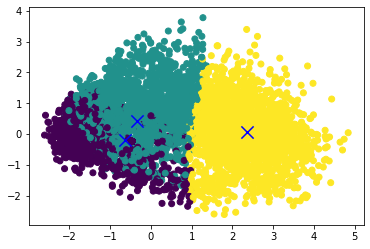

In [0]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(embedding_matrix))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [0]:
from sklearn.metrics import homogeneity_score
homogeneity_score(dfClustering.AssignmentGroup, cls.predict(desc_pad))

0.02749846404635668

For labelled data we use homogeneous labeling

The score ranges between 0 and 1 where 1 stands for perfectly homogeneous labeling.

Here the score is too less as almost 0, meaning the data is not homogeneous to consider for labelling using KMeans 

In [0]:
from sklearn.metrics import silhouette_score
silhouette_score(embedding_matrix, labels=cls.predict(embedding_matrix))

0.42332903919991327

This score is used for the unlabelled data. Our is not that case, so we can ignore this as such

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

### Check for optimal number of clusters using Elbow method

In [0]:
sqr_dist_sum = []
accuracy = []
clusters = range(1,10)

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(embedding_matrix)
    sqr_dist_sum.append(model.inertia_)

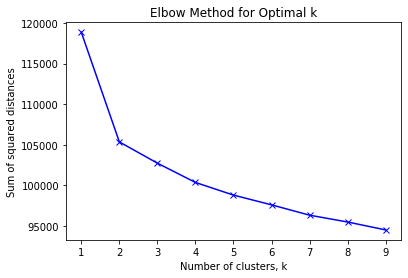

In [0]:
plt.plot(clusters, sqr_dist_sum, 'bx-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.xticks(clusters)
plt.show()

#### Analysis:

**Scatter Plot:**
- From the above scatter plot, we can see that there are four clusters while others seem to be scattered.

**Elbow Chart:**
- The Elbow chart shows that clustering is reduced significantly from K=1 to K=2. 
- The drop is still high when clusters increase from K=2 to K=5. 
- However, the drop is reduced when number of clusters increase from K=5 to K=6 and beyond.

## Building a Model

In [0]:
# X_test.shape

In [0]:
# vectorizer = TfidfVectorizer()
# train_vectors = vectorizer.fit_transform(X_train)
# test_vectors = vectorizer.transform(X_test)
# print(train_vectors.shape, test_vectors.shape)

In [0]:
# clf = MultinomialNB().fit(train_vectors, y_train)

In [0]:
# predicted = clf.predict(test_vectors)
# print(accuracy_score(y_test,predicted))

In [0]:
dfModelBuilding = dfCopySet[['LemmaString','AssignmentGroup']].copy()
dfModelBuilding.head()

,LemmaString,AssignmentGroup
0,login issue verify user detail employee mana...,GRP_0
1,outlook team meeting skype not appear calend...,GRP_0
2,ca not log vpn can not,GRP_0
3,unable access hr tool,GRP_0
5,unable log engineer tool skype,GRP_0


In [0]:
dfModelBuilding['AssignmentGroup'].value_counts().head(10)

GRP_0     3272
GRP_8      659
GRP_9      249
GRP_12     248
GRP_2      236
GRP_19     197
GRP_3      195
GRP_6      179
GRP_24     168
GRP_13     142
Name: AssignmentGroup, dtype: int64

In [0]:
# lets keep all assignement groups which have >= 200 tickets assigned to them
options = ['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19', 'GRP_3'] 
# dfTopGroups = dfModelBuilding.groupby(['AssignmentGroup']).size().sort_values(ascending=False)
# dfTopGroups = pd.DataFrame(dfTopGroups).reset_index()
# options = dfTopGroups[dfTopGroups['AssignmentGroup'] >= 200]['AssignmentGroup'].to_list()
options

['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19', 'GRP_3']

#### Remove blank Lemma strings

In [0]:
print ('Blank LemmaString: ', dfModelBuilding[(dfModelBuilding['LemmaString'] == ' ')].count() ['LemmaString'])

Blank LemmaString:  9


In [0]:
dfModelBuilding = dfModelBuilding.drop(dfModelBuilding[(dfModelBuilding['LemmaString'] == ' ')].index)
print(dfModelBuilding.shape)
dfModelBuilding.head()

(7427, 2)


,LemmaString,AssignmentGroup
0,login issue verify user detail employee mana...,GRP_0
1,outlook team meeting skype not appear calend...,GRP_0
2,ca not log vpn can not,GRP_0
3,unable access hr tool,GRP_0
5,unable log engineer tool skype,GRP_0


In [0]:
dfModelBuilding['TicketClass'] = np.where(dfModelBuilding['AssignmentGroup'].isin(options), 'L12', 'L3')

In [0]:
dfModelBuilding.head(2)

,LemmaString,AssignmentGroup,TicketClass
0,login issue verify user detail employee mana...,GRP_0,L12
1,outlook team meeting skype not appear calend...,GRP_0,L12


In [0]:
# handle the imbalanced dataset
 dfModelBuilding['TicketClass'].value_counts()

L12    5216
L3     2211
Name: TicketClass, dtype: int64

In [0]:
# Import label encoder 
from sklearn import preprocessing 
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dfModelBuilding['TicketTargets']= label_encoder.fit_transform(dfModelBuilding['TicketClass']) 
  
dfModelBuilding['TicketTargets'].unique()

array([0, 1])

# DATASET PARTITION


In [0]:
# this funtion helps to do a split for train and test data. It takes input as a dataframe 
# and a list of columns that may be needed to drop based om their relationship with the target variable
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    # print(df.columns)
    #test train split time
    y = df['TicketTargets'].values #target
    X = df['LemmaString'].values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
    
    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    test_vectors = vectorizer.transform(X_test)
    print(train_vectors.shape, test_vectors.shape)

    return train_vectors, test_vectors, y_train, y_test

## **FITTING and EVALUATING MODELS**


In [0]:
# model fitting
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('Train-set confusion matrix:\n', confusion_matrix(y_train,train_pred))
    return y_pred, y_pred_prob

In [0]:
# drawing roc curve
def roc_curve_draw(fpr, tpr, thr):
    # drawing roc curve
    idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensitivity > 0.95
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

## **VALIDATING MODELS**

In [0]:
def print_scores(y_test,y_pred,y_pred_prob):
    print("Accuracy score: \n", accuracy_score(y_test,y_pred))
    print('Test-set confusion matrix:\n', confusion_matrix(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='g')
    print("Classification report:" "\n", classification_report(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

## **Model Execution**

============================== Naive Bayes Classifier Model Starts ==============================
(5198, 7898) (2229, 7898)
Train-set confusion matrix:
 [[3630   21]
 [ 941  606]]
============================== Naive Bayes Classifier Model Evaluation ==============================
Accuracy score: 
 0.7572902646926873
Test-set confusion matrix:
 [[1546   19]
 [ 522  142]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.99      0.85      1565
           1       0.88      0.21      0.34       664

    accuracy                           0.76      2229
   macro avg       0.81      0.60      0.60      2229
weighted avg       0.79      0.76      0.70      2229

ROC AUC: 0.825598560375688


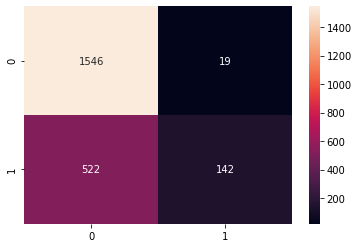

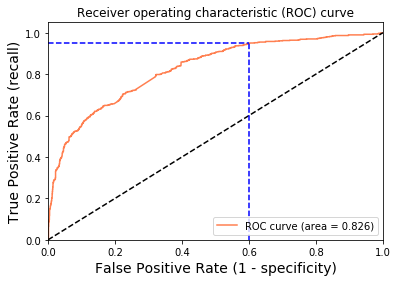

Using a threshold of 0.072 guarantees a sensitivity of 0.950 and a specificity of 0.399, i.e. a false positive rate of 60.13%.
============================== Naive Bayes Classifier Model Ends ==============================


============================== SVM Linear Model Starts ==============================
(5198, 7898) (2229, 7898)
Train-set confusion matrix:
 [[3564   87]
 [ 436 1111]]
============================== SVM Linear Model Evaluation ==============================
Accuracy score: 
 0.8088829071332436
Test-set confusion matrix:
 [[1453  112]
 [ 314  350]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1565
           1       0.76      0.53      0.62       664

    accuracy                           0.81      2229
   macro avg       0.79      0.73      0.75      2229
weighted avg       0.80      0.81      0.80      2229

ROC AUC: 0.8392567073405444


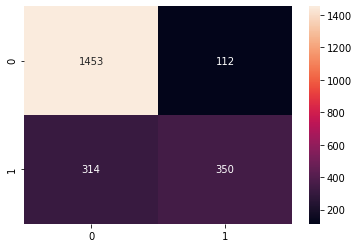

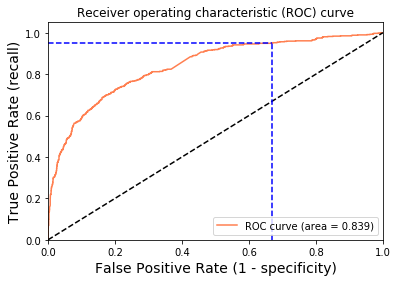

Using a threshold of 0.080 guarantees a sensitivity of 0.950 and a specificity of 0.332, i.e. a false positive rate of 66.77%.
============================== SVM Linear Model Ends ==============================


============================== SVM RBF Model Starts ==============================
(5198, 7898) (2229, 7898)
Train-set confusion matrix:
 [[3619   32]
 [ 262 1285]]
============================== SVM RBF Model Evaluation ==============================
Accuracy score: 
 0.8111260655002244
Test-set confusion matrix:
 [[1490   75]
 [ 346  318]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88      1565
           1       0.81      0.48      0.60       664

    accuracy                           0.81      2229
   macro avg       0.81      0.72      0.74      2229
weighted avg       0.81      0.81      0.79      2229

ROC AUC: 0.8453178528811732


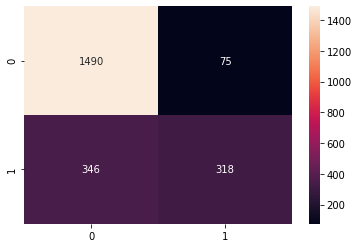

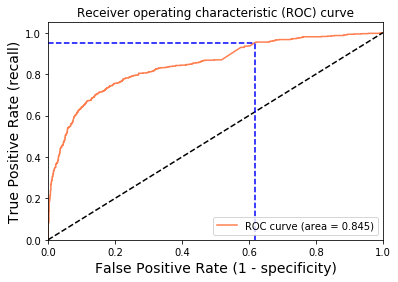

Using a threshold of 0.094 guarantees a sensitivity of 0.952 and a specificity of 0.383, i.e. a false positive rate of 61.73%.
============================== SVM RBF Model Ends ==============================


============================== XGBoost Model Starts ==============================
(5198, 7898) (2229, 7898)
Train-set confusion matrix:
 [[3600   51]
 [ 978  569]]
============================== XGBoost Model Evaluation ==============================
Accuracy score: 
 0.7792732166890982
Test-set confusion matrix:
 [[1532   33]
 [ 459  205]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.98      0.86      1565
           1       0.86      0.31      0.45       664

    accuracy                           0.78      2229
   macro avg       0.82      0.64      0.66      2229
weighted avg       0.80      0.78      0.74      2229

ROC AUC: 0.8126125909388352


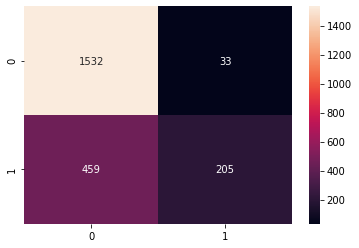

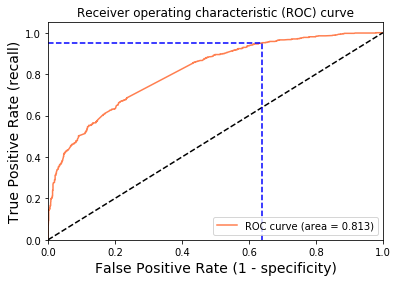

Using a threshold of 0.167 guarantees a sensitivity of 0.950 and a specificity of 0.360, i.e. a false positive rate of 63.96%.
============================== XGBoost Model Ends ==============================




In [0]:
drop_list = [] #to drop columns not affecting the model output
models = []

models.append(('Naive Bayes Classifier', MultinomialNB()))
models.append(('SVM Linear', svm.SVC(kernel='linear',probability=True)))
models.append(('SVM RBF', svm.SVC(kernel='rbf',probability=True)))
models.append(('XGBoost', XGBClassifier()))

# X_train, X_test, y_train, y_test = split_data(dfModelBuilding, drop_list)
for i,v in models:
    print('============================== {} Model Starts =============================='.format(i))
    X_train, X_test, y_train, y_test = split_data(dfModelBuilding, drop_list)
    y_pred, y_pred_prob = get_predictions(v, X_train, y_train, X_test)
    print('============================== {} Model Evaluation =============================='.format(i))
    print_scores(y_test,y_pred,y_pred_prob)
    [fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_prob[:,1])
    roc_curve_draw(fpr, tpr, thr)
    print('============================== {} Model Ends =============================='.format(i))
    print('\n')

#### Analysis:
- Naive Bayes: For threshold of 0.075, Accuracy=0.76, False positive rate= 61.58%
- SVM Linear:  For threshold of 0.093, Accuracy=0.82, False positive rate= 68.22%
- SVM RBF:     For threshold of 0.097, Accuracy=0.82, False positive rate= 62.22%
- XGBoost:	   For threshold of 0.204, Accuracy=0.78, False positive rate= 59.86%

False Positive represents assigning L1L2 ticket to L3 group incorrectly which is resulting in re-assignments. Based on this, we may opt for XGBoost approach which has least false positive rate.

### Regroup Assignment groups based on number of tickets to address imabalanced data
- Assignment groups with number of tickets <= 50 are assigned to GRP_99
- Assignment groups with number of tickets > 50 and <= 100 are assigned to GRP_98

In [0]:
dfModelBuilding.shape

(7427, 4)

In [0]:
dfModelBuilding['NewAssignmentGroup'] = dfModelBuilding['AssignmentGroup']
dfModelBuilding.head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
0,login issue verify user detail employee mana...,GRP_0,L12,0,GRP_0
1,outlook team meeting skype not appear calend...,GRP_0,L12,0,GRP_0
2,ca not log vpn can not,GRP_0,L12,0,GRP_0
3,unable access hr tool,GRP_0,L12,0,GRP_0
5,unable log engineer tool skype,GRP_0,L12,0,GRP_0


### Review duplicate tickets (same description/Lemma strings)
- Total number of Duplicate Lemma strings: 218 (tickets: 1560)
- Duplicate Lemma strings assigned to a single group: 175 (tickets: 636) - These are OK
- Duplicate Lemma strings assigned to different groups: 43 (tickets: 924) - These will be re-assigned

#### Group by LemmaString and take the count of NewAssignmentGroup

In [0]:
dfModelBuilding['LemmaString'] = dfModelBuilding['LemmaString'].apply(lambda x: x.strip())

In [0]:
grouped_data = pd.DataFrame(dfModelBuilding.groupby(by='LemmaString')['NewAssignmentGroup'].nunique())
grouped_data.rename(columns={'NewAssignmentGroup':'Count'}, inplace=True)
grouped_data.reset_index(inplace=True)

In [0]:
grouped_data.head(2)

,LemmaString,Count
0,abap report zsd price field update rqfhiong zk...,1
1,abap runtime error transaction zload system si...,1


#### Review tickets assigned to a single group - There are good


In [0]:
grouped_data[grouped_data['Count'] == 1].shape[0]

5809

### Reassign Group for **duplicate tickets** (same description/Lemma strings) which are assigned to multiple groups
- The Group with maximum number of tickets for the Lemma strings (Description) will be assigned

#### Sample of duplicate tickets assigned to multiple groups

In [0]:
dfModelBuilding[(dfModelBuilding['LemmaString'] == 'unable install engineer tool')].head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
1471,unable install engineer tool,GRP_0,L12,0,GRP_0
4176,unable install engineer tool,GRP_0,L12,0,GRP_0
4191,unable install engineer tool,GRP_25,L3,1,GRP_25
7863,unable install engineer tool,GRP_0,L12,0,GRP_0


In [0]:
dfModelBuilding[(dfModelBuilding['LemmaString'] == 'job fail scheduler monitor tool')].head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
47,job fail scheduler monitor tool,GRP_6,L3,1,GRP_6
60,job fail scheduler monitor tool,GRP_8,L12,0,GRP_8
67,job fail scheduler monitor tool,GRP_9,L12,0,GRP_9
68,job fail scheduler monitor tool,GRP_8,L12,0,GRP_8
69,job fail scheduler monitor tool,GRP_8,L12,0,GRP_8


In [0]:
# Prepare the set of LemmaStrings to be parsed (Count > 1)
LemmaStrings = set(grouped_data[grouped_data['Count'] > 1]['LemmaString'])

# For all LemmaStrings in the set, find out the maximum tickets assigned to a group and replace the new assignment group
for text in LemmaStrings:
  max_ticket_grp = dfModelBuilding[dfModelBuilding['LemmaString'] == text]['NewAssignmentGroup'].value_counts().idxmax()
  for i in dfModelBuilding[dfModelBuilding['LemmaString'] == text].index:
    dfModelBuilding.at[i, 'NewAssignmentGroup'] = max_ticket_grp

In [0]:
# Now Group by the LemmaString and take the count of AssignmentGroup
new_grouped_data = pd.DataFrame(dfModelBuilding.groupby(by='LemmaString')['NewAssignmentGroup'].nunique())
new_grouped_data.rename(columns={'NewAssignmentGroup':'Count'}, inplace=True)
new_grouped_data.reset_index(inplace=True)
new_grouped_data[new_grouped_data['Count'] > 1]

,LemmaString,Count


#### Review re-assignment of Group for duplicate tickets which were originally assigned to multiple groups

In [0]:
dfModelBuilding[(dfModelBuilding['LemmaString'] == 'unable install engineer tool')].head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
1471,unable install engineer tool,GRP_0,L12,0,GRP_0
4176,unable install engineer tool,GRP_0,L12,0,GRP_0
4191,unable install engineer tool,GRP_25,L3,1,GRP_0
7863,unable install engineer tool,GRP_0,L12,0,GRP_0


In [0]:
dfModelBuilding[(dfModelBuilding['LemmaString'] == 'job fail scheduler monitor tool')].head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
47,job fail scheduler monitor tool,GRP_6,L3,1,GRP_8
60,job fail scheduler monitor tool,GRP_8,L12,0,GRP_8
67,job fail scheduler monitor tool,GRP_9,L12,0,GRP_8
68,job fail scheduler monitor tool,GRP_8,L12,0,GRP_8
69,job fail scheduler monitor tool,GRP_8,L12,0,GRP_8


### Regroup the Assignment groups based on number of tickets to address unbalanced data
- Assignment groups with number of tickets <= 50 are assigned to GRP_99
- Assignment groups with number of tickets > 50 and <= 100 are assigned to GRP_98

In [0]:
dfGroup = dfModelBuilding.groupby(['NewAssignmentGroup']).size().sort_values(ascending=False).to_frame(name='Count').reset_index()
print(dfGroup.shape)
dfGroup.head()

(74, 2)


,NewAssignmentGroup,Count
0,GRP_0,3266
1,GRP_8,911
2,GRP_12,240
3,GRP_2,240
4,GRP_19,195


#### New Assignment Group 98 for groups with tickets > 50 <= 100

In [0]:
df98 = dfGroup[(dfGroup['Count'] > 50) & (dfGroup['Count'] <= 100)]
df98.shape

(10, 2)

In [0]:
dfModelBuilding['NewAssignmentGroup'] = np.where(dfModelBuilding['NewAssignmentGroup'].isin(df98['NewAssignmentGroup']), 'GRP_98', dfModelBuilding['NewAssignmentGroup'])

In [0]:
dfModelBuilding[(dfModelBuilding['NewAssignmentGroup'] == 'GRP_98')].head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
32,duplication network address gentles device sha...,GRP_4,L3,1,GRP_98
49,status not change telephony software close age...,GRP_7,L3,1,GRP_98
57,need dn material plant pcs,GRP_6,L3,1,GRP_98
63,urgent create dlv mm sto plant,GRP_6,L3,1,GRP_98
85,job apo bop plant fail scheduler monitor tool,GRP_6,L3,1,GRP_98


#### New Assignment Group 99 for groups with tickets <= 50

In [0]:
df99 = dfGroup[(dfGroup['Count'] <= 50)]
df99.shape

(51, 2)

In [0]:
dfModelBuilding['NewAssignmentGroup'] = np.where(dfModelBuilding['NewAssignmentGroup'].isin(df99['NewAssignmentGroup']), 'GRP_99', dfModelBuilding['NewAssignmentGroup'])
#dfModelBuilding['NewAssignmentGroup'] = np.where(dfModelBuilding['AssignmentGroup'].isin(df99['AssignmentGroup']), 'GRP_99', dfModelBuilding['NewAssignmentGroup'])

In [0]:
dfModelBuilding[(dfModelBuilding['NewAssignmentGroup'] == 'GRP_99')].head()

,LemmaString,AssignmentGroup,TicketClass,TicketTargets,NewAssignmentGroup
6,event critical hostname value mountpoint thres...,GRP_1,L3,1,GRP_99
84,engineer tool draw original pdf format not ser...,GRP_11,L3,1,GRP_99
141,channel partner receive multiple email erp urg...,GRP_15,L3,1,GRP_99
185,datum not correctly pull employee travel tool ...,GRP_20,L3,1,GRP_99
197,need approve product request,GRP_21,L3,1,GRP_99


### Update Ticket Class based on number of tickets in the group

In [0]:
#TicketGroups = set(data['NewAssignmentGroup'])
#
# For all groups in the set, find out the ticket class
#for grp in TicketGroups:
#  ticket_class = data[data['NewAssignmentGroup'] == grp]['TicketClass'].value_counts().idxmax()
#  for i in data[(data['NewAssignmentGroup'] == grp) & (data['TicketClass'] != ticket_class)].index:
#    data.at[i, 'TicketClass'] = ticket_class

In [0]:
dfGroup = dfModelBuilding.groupby(['NewAssignmentGroup']).size().sort_values(ascending=False).to_frame(name='Count').reset_index()
print(dfGroup.shape)
dfGroup.head()

(15, 2)


,NewAssignmentGroup,Count
0,GRP_0,3266
1,GRP_8,911
2,GRP_98,799
3,GRP_99,659
4,GRP_2,240


In [0]:
dfL12 = dfGroup[(dfGroup['Count'] >= 150) & (dfGroup['NewAssignmentGroup'] != 'GRP_98') & (dfGroup['NewAssignmentGroup'] != 'GRP_99')]
dfL12.shape

(8, 2)

In [0]:
dfModelBuilding['TicketClass'] = np.where(dfModelBuilding['NewAssignmentGroup'].isin(dfL12['NewAssignmentGroup']), 'L12', 'L3')

#### Review distribution of tickets across Ticket Class

In [0]:
dfModelBuilding.groupby(['TicketClass', 'NewAssignmentGroup']).size()

TicketClass  NewAssignmentGroup
L12          GRP_0                 3266
             GRP_12                 240
             GRP_19                 195
             GRP_2                  240
             GRP_24                 169
             GRP_3                  191
             GRP_8                  911
             GRP_9                  173
L3           GRP_10                 120
             GRP_13                 138
             GRP_14                 113
             GRP_25                 109
             GRP_5                  104
             GRP_98                 799
             GRP_99                 659
dtype: int64

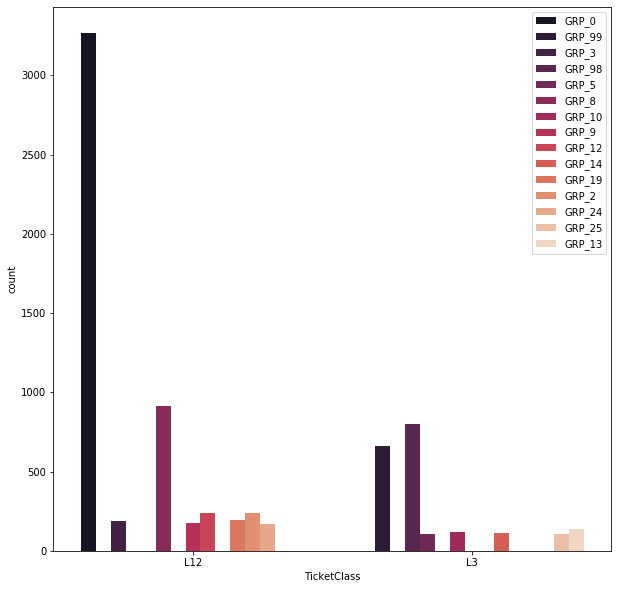

In [0]:
plt.figure(figsize=(10,10))
sns.countplot(data=dfModelBuilding, x='TicketClass', palette='rocket', hue='NewAssignmentGroup')
plt.legend(loc='upper right')
plt.show()

### Save cleaned & lemmatized data with re-assigned Groups and Ticket Class to Excel file which will be used by model training program

In [0]:
dfModelBuilding.to_excel("EDA_Processed_Cleaned_TicketData.xlsx", columns=['LemmaString', 'AssignmentGroup', 'NewAssignmentGroup', 'TicketClass'], header=True)